# 1.0 Importing Libraries and dataset :

### 0.0 Adding boundaries to the dataframes

In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

### 0.1 Adding Multiple outputs to the output cell : 

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 0.2 Horizantal display in output cell : 

In [3]:
# For easier understanding 

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

### 0.3 Importing relevant libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

### 0.4 Importing the datasets: 

In [5]:
# importing the dataset : 

df_raw = pd.read_csv('raw.csv')
df_flags = pd.read_csv('MBA_Filter_Master.csv')

df_raw.head(3)
df_raw.shape

df_flags.head(3)
df_flags.shape

,date,week_num,class,transaction_number,magento_id,sku,description,type,quantity,price,amount,customer_email,customer_id,Category1,transaction_order
0,2019-07-01,27,Retail - eCommerce,SO1357725,1074604,NUT05-00034,Fudge Brownie Collagen Protein Bar - 4 pack,Sales Order,1.0,11.95,11.95,elsie_lynn@hotmail.com,16046377,Bars & Bites,1
1,2019-07-01,27,Retail - eCommerce,SO1357677,1074556,NUT08-00023,Polyphenomenal 2.0 - 120 Ct.,Sales Order,3.0,39.95,119.85,mj.macaskill@hotmail.com,16045784,Supplements,1
2,2019-07-01,27,Retail - eCommerce,SO1358017,NaN,BEV01-00013,RTD BP Coffee Collgn Variety 12ct Case,Sales Order,1.0,59.88,0.00,cameronorogers@gmail.com,15278428,RTD,7


(673286, 15)

,sku,SKU_Discount_Flag,KIT_Flag
0,NUT05-00033,0,0
1,ACC11-00059,0,0
2,NUT08-00011,0,0


(168, 3)

In [6]:
'''We are only cosidering Class variable = Retail ecommerce '''

df_raw[df_raw['class'] == 'Retail - eCommerce'].shape

'We are only cosidering Class variable = Retail ecommerce '

(620388, 15)

### 0.5 Function for preprocessing : 

In [7]:
def pre_processing(x,y):
    # call the function as in this way : data_discount_2, data_contains_kits, discounted_data_no_kits = pre_processing(x,y)
    # where x and y are two dataframes
    
    '''
    This is a preprocessing function to segregate the default raw csv data into different
    dataframe based on the presence/absence of discount, kits.
    
    '''
    
    # subsetting only retail_ecommerce data 
    df_data = x[x['class'] == 'Retail - eCommerce']
 
    # merging with sku level flag data
    data=df_data.merge(y, on='sku', how='left')
    # groupby by sku discount flag
    df_dis=data.groupby(['transaction_number'])['SKU_Discount_Flag'].sum().reset_index()
    
    # creating transaction discount flag based on sku 
    df_dis['Transaction_Discount_Flag'] = np.where(df_dis['SKU_Discount_Flag']>0,1,0)
    df_dis.drop(columns='SKU_Discount_Flag',inplace=True)
    # merging to original data source
    data_2=data.merge(df_dis, on='transaction_number', how='left')
    
    # segregating discount and non discount datasets: 
    
    # preprocessing of discounted datasets : 
    data_discount=data_2[(data_2['Transaction_Discount_Flag'] == 1 )]
    # removing discount row from transactional data
    data_discount_final=data_discount[(data_discount['SKU_Discount_Flag'] == 0 )]
    
    # removing freebies (i.e. amount != 0)
    data_discount_final = data_discount_final[data_discount_final['amount'] != 0]
 
    
    # segregating process of kits and non kits 
    df_kit=data.groupby(['transaction_number'])['KIT_Flag'].sum().reset_index()
    # creating transaction kit flag
    df_kit['Transaction_Kit_Flag'] = np.where(df_kit['KIT_Flag']>0,1,0)
    df_kit.drop(columns='KIT_Flag',inplace=True)
    # merging with discount 
    data_kit_discount=data_discount_final.merge(df_kit, on='transaction_number', how='left')
    data_contains_kits_discount=data_kit_discount[(data_kit_discount['Transaction_Kit_Flag'] == 1 )]
    data_no_kits_discount=data_kit_discount[(data_kit_discount['Transaction_Kit_Flag'] == 0 )]
    
    # removing kit row from the discounted datasets
    data_discount_final_excl_kit_rows = data_kit_discount[data_kit_discount['KIT_Flag'] == 0]
    
    # pre processing of non discount data : 
    
    # segregating discount and non discount datasets 
    data_non_discount=data_2[(data_2['Transaction_Discount_Flag'] == 0 )]
    # segregating process of kits and non kits
    # merging with discount 
    data_kit_non_discount=data_non_discount.merge(df_kit, on='transaction_number', how='left')
    data_contains_kits_non_discount=data_kit_non_discount[(data_kit_non_discount['Transaction_Kit_Flag'] == 1 )]
    data_no_kits_non_discount=data_kit_non_discount[(data_kit_non_discount['Transaction_Kit_Flag'] == 0 )]
    # removing kit row from the discounted datasets
    data_non_discount_final_excl_kit_rows = data_kit_non_discount[data_kit_non_discount['KIT_Flag'] == 0]
    
    
    return (data_discount_final, data_non_discount, data_discount_final_excl_kit_rows,data_non_discount_final_excl_kit_rows,
            data_contains_kits_discount,data_no_kits_discount,data_contains_kits_non_discount,data_no_kits_non_discount)


# 2.0 Data Wrangling : 


## 2.1 Preprocessing with funtion : 

In [8]:
'''Calling the preprocessing function to get the  different dataframes'''

data_discount_final, data_non_discount, data_discount_final_excl_kit_rows,data_non_discount_final_excl_kit_rows,data_contains_kits_discount,data_no_kits_discount,data_contains_kits_non_discount,data_no_kits_non_discount = pre_processing(df_raw,df_flags)

'Calling the preprocessing function to get the  different dataframes'

In [9]:
'''Shape of the various dataframes after running through the preprocessing function : '''

data_discount_final.shape
data_non_discount.shape 
data_discount_final_excl_kit_rows.shape
data_non_discount_final_excl_kit_rows.shape
data_contains_kits_discount.shape
data_no_kits_discount.shape
data_contains_kits_non_discount.shape
data_no_kits_non_discount.shape

'Shape of the various dataframes after running through the preprocessing function : '

(345589, 18)

(2014, 18)

(341124, 19)

(1733, 19)

(46792, 19)

(298797, 19)

(805, 19)

(1209, 19)

In [10]:
# # Converting the preprocessed datasets to csv :

# data_discount_final.to_csv('data_discount_final.csv',index = False)
# data_non_discount.to_csv('data_non_discount.csv',index = False)
# data_discount_final_excl_kit_rows.to_csv('data_discount_final_excl_kit_rows.csv',index = False)
# data_non_discount_final_excl_kit_rows.to_csv('data_non_discount_final_excl_kit_rows.csv',index = False)
# data_contains_kits_discount.to_csv('data_contains_kits_discount',index = False)
# data_no_kits_discount.to_csv('data_no_kits_discount.csv',index = False)
# data_contains_kits_non_discount.to_csv('data_contains_kits_non_discount.csv',index = False)
# data_no_kits_non_discount.to_csv('data_no_kits_non_discount.csv',index = False)
# data_final_discount_non_discount_merged.to_csv('data_final_discount_non_discount_merged.csv',index = False)

# 3.0 MBA using Apriori : 

* **For this exercise we will be working on the data_discount_final dataframe we had created above using the preprocessing function :**

In [11]:
# reimporting the data_discount_final.csv 

df = pd.read_csv('data_discount_final.csv')
df.head()
df.shape

,date,week_num,class,transaction_number,magento_id,sku,description,type,quantity,price,amount,customer_email,customer_id,Category1,transaction_order,SKU_Discount_Flag,KIT_Flag,Transaction_Discount_Flag
0,2019-07-01,27,Retail - eCommerce,SO1357725,1074604,NUT05-00034,Fudge Brownie Collagen Protein Bar - 4 pack,Sales Order,1.0,11.95,11.95,elsie_lynn@hotmail.com,16046377,Bars & Bites,1,0.0,0.0,1
1,2019-07-01,27,Retail - eCommerce,SO1357677,1074556,NUT08-00023,Polyphenomenal 2.0 - 120 Ct.,Sales Order,3.0,39.95,119.85,mj.macaskill@hotmail.com,16045784,Supplements,1,0.0,0.0,1
2,2019-07-01,27,Retail - eCommerce,SO1357649,1074528,CDK01-00041,The Mentalist Coffee Pods - 24CT,Sales Order,3.0,29.99,80.97,jimbobia@me.com,7803472,Packaged Coffee,10,0.0,0.0,1
3,2019-07-01,27,Retail - eCommerce,SO1357333,1074232,NUT08-00032,Omega Krill Complex – 120 Ct.,Sales Order,1.0,49.95,47.45,debracsharpe@gmail.com,131735,Supplements,68,0.0,0.0,1
4,2019-07-01,27,Retail - eCommerce,SO1357807,1074678,NUT08-00029,Vitamins A-D-K - 30 Ct.,Sales Order,1.0,39.95,23.97,fcalkins@mac.com,13334591,Supplements,26,0.0,0.0,1


(345589, 18)

### Steps to follow for using the MBA alogorithm : 

* **Step 1 : For MBA, we do not require all the features.Thus, we will be selecting only the features which will be required.**

  * `In our dataframe, the features which we will be requiring will be :` **`transaction_number,description,quantity`**

In [12]:
# Selecting the required columns : 

df_discount = df[['transaction_number', 'description','quantity']]
df_discount.head()
df_discount.shape

,transaction_number,description,quantity
0,SO1357725,Fudge Brownie Collagen Protein Bar - 4 pack,1.0
1,SO1357677,Polyphenomenal 2.0 - 120 Ct.,3.0
2,SO1357649,The Mentalist Coffee Pods - 24CT,3.0
3,SO1357333,Omega Krill Complex – 120 Ct.,1.0
4,SO1357807,Vitamins A-D-K - 30 Ct.,1.0


(345589, 3)

* **Step 2 :** **For MBA alogrithm, the data needs to be provided in a specific format such that we have a `transaction numbers`as index and `the names of products` as the column names.The rows would then cosist of values which indicate the how many products are present per transaction number**

In [13]:
# Creating the matrix : 


basket = (df_discount.groupby(['transaction_number', 'description'])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('transaction_number'))
basket.head()

description,3 - Pack French Kick Dark Roast 12oz Ground,3 - Pack French Kick Dark Roast 12oz Whole Bean,3 - Pack The Mentalist Dark Roast 12oz Ground,3 - Pack The Mentalist Dark Roast 12oz Whole Bean,3 - Pack The Original 12oz Ground,3 - Pack The Original 12oz Ground Decaf,3 - Pack The Original 12oz Whole Bean,3 - Pack The Original 12oz Whole Bean Decaf,3-Roast Coffee Variety Pack Ground,3-Roast Coffee Variety Pack Whole Bean,5-HTP - 90 Ct.,AirScape Kitchen Canister,Apple Pie Collagen Protein Bar (12 pack),Brain & Cell Power,Brain Octane GoPacks - (Caddie),Brain Octane GoPacks - 15 ct,Brain Octane Oil - 16 oz.,Brain Octane Oil - 3 oz.,Brain Octane Oil - 3 pack (16oz),Brain Octane Oil - 3 pack (32oz),Brain Octane Oil - 32 oz.,Brain Octane Softgels 60 Ct.,Bulletproof Beaker 14 oz.,Bulletproof Coffee & Ghee Kit,Bulletproof Coffee Cold Brew Caramel 12ct Case,Bulletproof Coffee Cold Brew Dark Chocolate + Collagen Protein 12ct Case,Bulletproof Coffee Cold Brew Mocha 12ct Case,Bulletproof Coffee Cold Brew Original + Collagen Protein 12ct Case,Bulletproof Coffee Cold Brew Original 12ct Case,Bulletproof Coffee Cold Brew Sampler 4ct Case,Bulletproof Coffee Cold Brew Vanilla 12ct Case,Bulletproof Coffee Cold Brew Vanilla Latte + Collagen Protein 12ct Case,Bulletproof Cookbook,Bulletproof Diet Book - Paperback,Bulletproof T-Shirt - Men's,Bulletproof T-Shirt - Women's,Bulletproof Travel Mug,Cacao Butter Net Wt. 16 oz.,Calcium D-Glucarate - 90 Ct.,Chocolate Chip Cookie Dough Collagen Protein Bar (12 pack),Chocolate Collagen Protein Net Wt. 17.6 oz.,Chocolate Fuel Bars - Himalayan Sea Salt (3pack) Net Wt. 5.94 oz.,Chocolate Fuel Bars – Original Dark (3pack) Net Wt. 5.94 oz.,Chocolate Fuel Bars – Variety (3pack) Net Wt. 5.94 oz.,Coconut Charcoal - 90 Ct.,Coffee Kit - Brain Octane Edition,"Coffee Kit – Brain Octane Oil, Ghee & Ground","Coffee Kit – Brain Octane Oil, Ghee & Pods",Coffee Starter Kit - Brain Octane Edition,Coffee Starter Kit - Brain Octane and Ground Coffee Edition,Collagelatin Net Wt. 16 oz.,Collagen Bar Classics Bundle (3 boxes of 12 bars),Collagen Protein GoPacks (15 count),Collagen Protein Net Wt. 17.6oz,Collagen Protein Net Wt. 8.5oz,Cookie Dough Collagen Protein Bar - 4 pack,Curcumin Max - 60 Ct.,Diet Roadmap Poster,Eye Armor - 60 Ct.,FATwater Grapefruit 12ct Case,FATwater Lemon 12ct Case,FATwater Pineapple 12ct Case,FATwater Variety 12ct Case,Flavored Collagen Variety Bundle,Forbose - 60 Ct.,French Kick Coffee Pods - 10CT,French Kick Coffee Pods - 24CT,French Kick Dark Roast Ground - 12oz,French Kick Dark Roast Whole Bean - 12oz,French Kick Dark Roast Whole Bean Coffee - 5lb,Fudge Brownie Collagen Protein Bar (12 Pack),Fudge Brownie Collagen Protein Bar - 4 pack,Game Changers Book,Glutathione Force - 90 Ct.,Grass-Fed Ghee – 13.5 oz,Grass-fed Ghee - 8 oz,Head Strong,High On Octane T-Shirt - Women's,InstaMix,KetoPrime,Lemon Cookie Collagen Protein Bar (12 pack),Luminate Light Roast Ground - 12oz,Luminate Light Roast Whole Bean - 12oz,Methyl B-12 - 60 Ct.,Mint Chocolate Chip Collagen Protein Bar (12 pack),MitoSweet - 8.5 oz,NeuroMaster - 30 Ct.,New XCT Oil - 32 oz.,Omega Krill Complex – 120 Ct.,Polyphenomenal 2.0 - 120 Ct.,Prebiotic Blend - 13.4 oz,RTD BP Coffee Collgn Variety 12ct Case,RTD BP Coffee Dk. Choc. Collagen 4-Pack,RTD BP Coffee Orig Collagen 4-Pack,RTD BP Coffee Van. Latte Collagen 4-Pack,RTD Dk Choc w/ Coll 12 Ct,Sleep Induction Mat,Sleep Mode - 60 Ct.,Small Batch Mlama Ground Coffee - 12oz,Small Batch Mlama Whole Bean Coffee - 12oz,Small Batch San Cristobal Ground Coffee - 12o,Small Batch San Cristobal Whole Bean Coffee - 12oz,Stainless Steel Insulated Bottle,Super Human Book,The Better Baby Book,The Bulletproof Diet Book,The Mentalist Coffee Pods - 10CT,The Mentalist Coffee Pods - 24CT,The Mentalist Coffee Pods 24ct - 3 Pack,The Mentalist Dark Roast Whole Bean Coffee - 5lb,The Mentalist Medium Dark Roast Ground - 12oz,The Mentalist Medium Dark Roast Whole Bean - 12oz,The Original Coffee Pods - 10CT,The Original

* **Step 3 :**

* **We using one hot encoding such that any numbers greater 1, would give us 1 else 0.**
* **We do this because at the end of the day,what we are concerned about weather a certain transaction number has a specific product or not.We do not require the number of occurance of a product per transaction number.**

In [14]:
# Convert the units to 1 hot encoded values
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [15]:
# Applying oHE on the df
# applymap() is typically used for elementwise operations
basket_sets = basket.applymap(encode_units)

* **Step 4 :**

* **We then use the apriori algorithm to create Frequent itemsets by calling the `apriori function` and then we create the `rules based on these frequent itemsets.`**

In [16]:
# sup = 0.002 since we want that a product should have atleast a minimum of 2% in the transactions.

frequent_itemsets = apriori(basket_sets, min_support=0.002, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.011212,(Apple Pie Collagen Protein Bar (12 pack))
1,0.011487,(Brain Octane GoPacks - (Caddie))
2,0.008916,(Brain Octane GoPacks - 15 ct)
3,0.147615,(Brain Octane Oil - 16 oz.)
4,0.005405,(Brain Octane Oil - 3 oz.)
5,0.121864,(Brain Octane Oil - 32 oz.)
6,0.013897,(Brain Octane Softgels 60 Ct.)
7,0.002869,(Bulletproof Beaker 14 oz.)
8,0.015251,(Bulletproof Coffee Cold Brew Caramel 12ct Case)
9,0.007006,(Bulletproof Coffee Cold Brew Dark Chocolate + Collagen Protein 12ct Case)


In [17]:
# Creating the rules : 

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Apple Pie Collagen Protein Bar (12 pack)),(Chocolate Chip Cookie Dough Collagen Protein Bar (12 pack)),0.011212,0.026709,0.003316,0.295803,11.074997,0.003017,1.382130
1,(Chocolate Chip Cookie Dough Collagen Protein Bar (12 pack)),(Apple Pie Collagen Protein Bar (12 pack)),0.026709,0.011212,0.003316,0.124168,11.074997,0.003017,1.128970
2,(Apple Pie Collagen Protein Bar (12 pack)),(Lemon Cookie Collagen Protein Bar (12 pack)),0.011212,0.036813,0.003483,0.310645,8.438394,0.003070,1.397229
3,(Lemon Cookie Collagen Protein Bar (12 pack)),(Apple Pie Collagen Protein Bar (12 pack)),0.036813,0.011212,0.003483,0.094607,8.438394,0.003070,1.092110
4,(Apple Pie Collagen Protein Bar (12 pack)),(Vanilla Shortbread Collagen Protein Bar (12 Pack)),0.011212,0.058433,0.003592,0.320368,5.482661,0.002937,1.385408
5,(Vanilla Shortbread Collagen Protein Bar (12 Pack)),(Apple Pie Collagen Protein Bar (12 pack)),0.058433,0.011212,0.003592,0.061469,5.482661,0.002937,1.053549
6,(Brain Octane Oil - 16 oz.),(Brain Octane GoPacks - (Caddie)),0.147615,0.011487,0.002662,0.018036,1.570091,0.000967,1.006669
7,(Brain Octane GoPacks - (Caddie)),(Brain Octane Oil - 16 oz.),0.011487,0.147615,0.002662,0.231768,1.570091,0.000967,1.109542
8,(Brain Octane Oil - 16 oz.),(Collagen Protein Net Wt. 8.5oz),0.147615,0.012015,0.003919,0.026548,2.209606,0.002145,1.014930
9,(Collagen Protein Net Wt. 8.5oz),(Brain Octane Oil - 16 oz.),0.012015,0.147615,0.003919,0.326170,2.209606,0.002145,1.264986


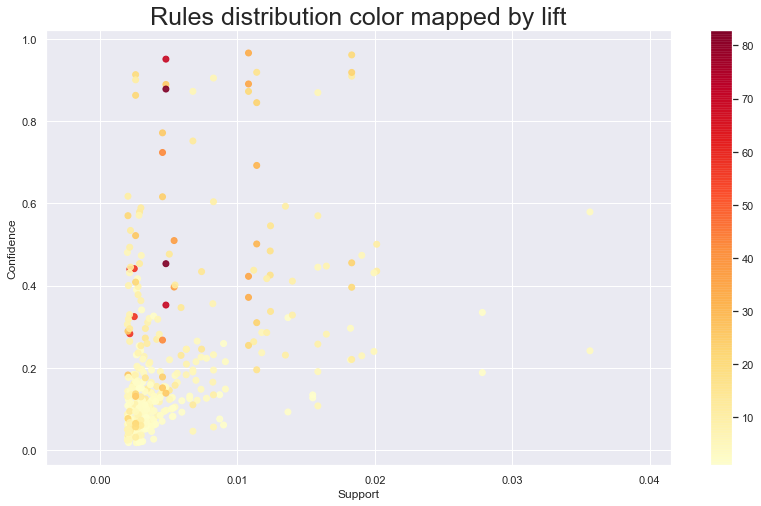

In [23]:
# Visualizing the rules distribution color mapped by Lift
plt.figure(figsize=(14, 8))
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], alpha=0.9, cmap='YlOrRd');
plt.title('Rules distribution color mapped by lift', fontsize = 25);
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar();

# 4.0 Filtering rules by antecedents length : 

* **One of the drawbacks of the apriori algorithm in python is that it does't let us specify the antecedent length by default.
Thus,we have to go about a round about way to implement this feature into the rules.**

* **This is mainly done by using a lambda function to check for the length of the antecedents and adding that as a new feature into the datafarame with the rules we created above.Thus, we can then filter the rules dataframes based on the desired length of the antecedent length.**

In [18]:
# compute the antecedent length

rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(Apple Pie Collagen Protein Bar (12 pack)),(Chocolate Chip Cookie Dough Collagen Protein Bar (12 pack)),0.011212,0.026709,0.003316,0.295803,11.074997,0.003017,1.382130,1
1,(Chocolate Chip Cookie Dough Collagen Protein Bar (12 pack)),(Apple Pie Collagen Protein Bar (12 pack)),0.026709,0.011212,0.003316,0.124168,11.074997,0.003017,1.128970,1
2,(Apple Pie Collagen Protein Bar (12 pack)),(Lemon Cookie Collagen Protein Bar (12 pack)),0.011212,0.036813,0.003483,0.310645,8.438394,0.003070,1.397229,1
3,(Lemon Cookie Collagen Protein Bar (12 pack)),(Apple Pie Collagen Protein Bar (12 pack)),0.036813,0.011212,0.003483,0.094607,8.438394,0.003070,1.092110,1
4,(Apple Pie Collagen Protein Bar (12 pack)),(Vanilla Shortbread Collagen Protein Bar (12 Pack)),0.011212,0.058433,0.003592,0.320368,5.482661,0.002937,1.385408,1
5,(Vanilla Shortbread Collagen Protein Bar (12 Pack)),(Apple Pie Collagen Protein Bar (12 pack)),0.058433,0.011212,0.003592,0.061469,5.482661,0.002937,1.053549,1
6,(Brain Octane Oil - 16 oz.),(Brain Octane GoPacks - (Caddie)),0.147615,0.011487,0.002662,0.018036,1.570091,0.000967,1.006669,1
7,(Brain Octane GoPacks - (Caddie)),(Brain Octane Oil - 16 oz.),0.011487,0.147615,0.002662,0.231768,1.570091,0.000967,1.109542,1
8,(Brain Octane Oil - 16 oz.),(Collagen Protein Net Wt. 8.5oz),0.147615,0.012015,0.003919,0.026548,2.209606,0.002145,1.014930,1
9,(Collagen Protein Net Wt. 8.5oz),(Brain Octane Oil - 16 oz.),0.012015,0.147615,0.003919,0.326170,2.209606,0.002145,1.264986,1


* **For eg:Say we want to filter the rules based on the following criterions.**

* **rules with at least 2 antecedents**
* **a confidence > 0.75**
* **a lift score > 1.2**

In [19]:
# use pandas' selection syntax :

rules_len_2 = rules[ (rules['antecedent_len'] >= 2) &
       (rules['confidence'] > 0.75) &
       (rules['lift'] > 1.2) ]
rules_len_2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
287,"(Grass-Fed Ghee – 13.5 oz, The Original Coffee Pods - 24CT)",(Brain Octane Oil - 16 oz.),0.007757,0.147615,0.006771,0.872781,5.912568,0.005625,6.700146,2
288,"(Brain Octane Oil - 16 oz., The Original Coffee Pods - 24CT)",(Grass-Fed Ghee – 13.5 oz),0.009002,0.061531,0.006771,0.752071,12.222563,0.006217,3.785237,2
294,"(Grass-Fed Ghee – 13.5 oz, The Original Ground Coffee - 12oz)",(Brain Octane Oil - 16 oz.),0.018235,0.147615,0.015859,0.869729,5.891895,0.013167,6.543191,2
300,"(Grass-Fed Ghee – 13.5 oz, The Original Whole Bean Coffee - 12oz)",(Brain Octane Oil - 16 oz.),0.009134,0.147615,0.008268,0.905151,6.131854,0.006920,8.986739,2
334,"(Forbose - 60 Ct., KetoPrime)",(NeuroMaster - 30 Ct.),0.005910,0.030135,0.004561,0.771845,25.613280,0.004383,4.250900,2
340,"(French Kick Coffee Pods - 24CT, The Mentalist Coffee Pods - 24CT)",(The Original Coffee Pods - 24CT),0.005405,0.034736,0.004808,0.889597,25.610067,0.004620,8.743062,2
341,"(French Kick Coffee Pods - 24CT, The Original Coffee Pods - 24CT)",(The Mentalist Coffee Pods - 24CT),0.005055,0.013627,0.004808,0.951192,69.801460,0.004739,20.209175,2
342,"(The Mentalist Coffee Pods - 24CT, The Original Coffee Pods - 24CT)",(French Kick Coffee Pods - 24CT),0.005474,0.010603,0.004808,0.878407,82.842594,0.004750,8.136935,2
346,"(French Kick Dark Roast Ground - 12oz, The Original Ground Coffee - 12oz)",(The Mentalist Medium Dark Roast Ground - 12oz),0.019055,0.046252,0.018321,0.961457,20.787446,0.017439,24.745294,2
347,"(French Kick Dark Roast Ground - 12oz, The Mentalist Medium Dark Roast Ground - 12oz)",(The Original Ground Coffee - 12oz),0.020139,0.083088,0.018321,0.909687,10.948466,0.016647,10.152558,2


* **Thus we have the rules we require, with a minimum antecedent length of 2.**

In [20]:
# e.g
# List of top 10 rules sorted by lift : 

rules_len_2.sort_values('lift', ascending= False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
342,"(The Mentalist Coffee Pods - 24CT, The Original Coffee Pods - 24CT)",(French Kick Coffee Pods - 24CT),0.005474,0.010603,0.004808,0.878407,82.842594,0.004750,8.136935,2
341,"(French Kick Coffee Pods - 24CT, The Original Coffee Pods - 24CT)",(The Mentalist Coffee Pods - 24CT),0.005055,0.013627,0.004808,0.951192,69.801460,0.004739,20.209175,2
354,"(The Original Whole Bean Coffee - 12oz, The Mentalist Medium Dark Roast Whole Bean - 12oz)",(French Kick Dark Roast Whole Bean - 12oz),0.012141,0.025585,0.010816,0.890832,34.819155,0.010505,8.925814,2
352,"(French Kick Dark Roast Whole Bean - 12oz, The Original Whole Bean Coffee - 12oz)",(The Mentalist Medium Dark Roast Whole Bean - 12oz),0.011194,0.029107,0.010816,0.966171,33.193208,0.010490,28.700171,2
334,"(Forbose - 60 Ct., KetoPrime)",(NeuroMaster - 30 Ct.),0.005910,0.030135,0.004561,0.771845,25.613280,0.004383,4.250900,2
340,"(French Kick Coffee Pods - 24CT, The Mentalist Coffee Pods - 24CT)",(The Original Coffee Pods - 24CT),0.005405,0.034736,0.004808,0.889597,25.610067,0.004620,8.743062,2
359,"(Fudge Brownie Collagen Protein Bar (12 Pack), Vanilla Shortbread Collagen Protein Bar (12 Pack))",(Lemon Cookie Collagen Protein Bar (12 pack)),0.013501,0.036813,0.011412,0.845304,22.961936,0.010915,6.226314,2
348,"(The Original Ground Coffee - 12oz, The Mentalist Medium Dark Roast Ground - 12oz)",(French Kick Dark Roast Ground - 12oz),0.019939,0.040216,0.018321,0.918849,22.847993,0.017519,11.827129,2
378,"(Brain Octane Oil - 16 oz., The Original Ground Coffee - 12oz, The Mentalist Medium Dark Roast Ground - 12oz)",(French Kick Dark Roast Ground - 12oz),0.003018,0.040216,0.002605,0.863118,21.462191,0.002484,7.011757,3
346,"(French Kick Dark Roast Ground - 12oz, The Original Ground Coffee - 12oz)",(The Mentalist Medium Dark Roast Ground - 12oz),0.019055,0.046252,0.018321,0.961457,20.787446,0.017439,24.745294,2
